In [3]:
import subprocess
from IPython.display import Image
import os.path
def plotbtree(btree, fname, redo=False, augmented=False):
    if os.path.exists(fname+".png") and not redo:
        return Image(fname+".png")
    start="""
    digraph G {
    nodesep=0.3;
    ranksep=0.2;
    margin=0.1;
    node [shape=circle];
    edge [arrowsize=0.8];
    """
    end = "}"
    assert btree.isRoot(), "Must start at root"
    lines=""
    labeldict={}
    for t in btree.preorder():
        if not t[0].uuid in labeldict:
            labeldict[t[0].uuid]=t[0]
        if not t[1].uuid in labeldict:
            labeldict[t[1].uuid]=t[1]
        lines = lines + "\"{}\" -> \"{}\"[side={}];\n".format(t[0].uuid,t[1].uuid,t[2])
    if augmented:
        end="\n".join(["\"{}\"[label=<{}<BR/><FONT POINT-SIZE=\"10\">{},{}</FONT>>]".format(k,v.data,v.size, v.count) for (k, v) in labeldict.items()])+end
    else:
        end="\n".join(["\"{}\"[label=<{}<BR/><FONT POINT-SIZE=\"10\">count={}</FONT>>]".format(k,v.data,v.count) for (k, v) in labeldict.items()])+end
       
    start = start + lines +end
    with open(fname+".dot","w") as fd:
        fd.write(start)
    subprocess.call(['./treeplot.sh', fname])
    return Image(fname+".png")

In [4]:
import uuid
class BinaryTree:
    def __init__(self, data, parent=None):
        self.data = data
        self.parent = parent
        self.uuid= uuid.uuid4()
        self.left = None
        self.right = None    
            
    def addLeftChild(self, data): 
        n = self.__class__(data, self)
        self.left = n
        return n
        
    def addRightChild(self, data):
        n = self.__class__(data, self)
        self.right = n
        return n
        
    def hasLeftChild(self):
        return self.left is not None

    def hasRightChild(self):
        return self.right is not None

    def hasAnyChild(self):
        return self.hasRightChild() or self.hasLeftChild()

    def hasBothChildren(self):
        return self.hasRightChild() and self.hasLeftChild()
    
    def hasNoChildren(self):
        return not self.hasRightChild() and not self.hasLeftChild()
    
    def isLeftChild(self):
        return self.parent and self.parent.left == self

    def isRightChild(self):
        return self.parent and self.parent.right == self

    def isRoot(self):
        return not self.parent

    def isLeaf(self):
        return not (self.right or self.left)
    
            
    def preorder(self):
        if self.isLeftChild():
            yield (self.parent, self, "left")
        elif self.isRightChild():
            yield (self.parent, self, "right")
        if self.hasLeftChild():
            for v in self.left.preorder():
                yield v
        if self.hasRightChild():
            for v in self.right.preorder():
                yield v


In [5]:
class BinarySearchTree(BinaryTree):
        
    def __init__(self, data, parent=None):
        super().__init__(data, parent)
        self.count = 1

    def _insert_hook(self):
        pass
            
    def insert(self, data):
        if data < self.data:
            if self.hasLeftChild():
                self.left.insert(data)
            else:
                self.addLeftChild(data)
                self._insert_hook()
        elif data > self.data:
            if self.hasRightChild():
                self.right.insert(data)
            else:
                self.addRightChild(data)
                self._insert_hook()
        else: #duplicate value
            self.count += 1
            self._insert_hook()
            
    def search(self, data):
        if self.data == data:
            return self
        elif data < self.data and self.left:
            return self.left.search(data)
        elif data > self.data and self.right:
            return self.right.search(data)
        else:
            return None
        
    def delete(self, data):        
        if self.isRoot() and self.hasNoChildren() and self.data==data:#deleting the whole tree
            self.root=None#todo call a destructor that signals GC it can reap
            #self._update_sizes(up=False) #really tree is gone
            self._remove_hook()
        elif self.hasAnyChild():
            noder = self.search(data)
            if noder:
                self._remove(noder)
            else:
                raise ValueError("No such data {} in tree".format(data))
        else:
            raise ValueError("No such data {} in tree".format(data))

    def _remove_hook(self, up=False, by=1):
        pass
    
    def _remove(self, node):
        if node.isLeaf():
            if node.isLeftChild():
                node.parent.left = None
            else:
                node.parent.right = None
            #node._update_sizes(up=False, by=node.count)
            node._remove_hook(by=node.count)
            del node
        elif node.hasBothChildren():
            s = node.successor()
            #successor is guaranteed to have right child only
            s.spliceOut()
            #s._update_sizes(up=False, by=s.count)
            s._remove_hook(by=s.count)
            #handled more generally above
            #s.right.parent = s.parent
            #s.parent.left = s.right
            node.data = s.data
            #diff = s.count - node.count            
            #node._update_sizes(by=diff)
            node._remove_hook(up=True, by = s.count - node.count)
            node.count = s.count
            del s #the node became the successor
        else: # one child case
            if node.hasLeftChild():
                if node.isLeftChild():
                    node.left.parent = node.parent
                    node.parent.left = node.left
                elif node.isRightChild():
                    node.left.parent = node.parent
                    node.parent.right = node.left
                else: #root
                    self.root = node.left
                #node._update_sizes(up=False, by=node.count)
                node._remove_hook(by=node.count)
                del node
            else:
                if node.isLeftChild():
                    node.right.parent = node.parent
                    node.parent.left = node.right
                elif node.isRightChild():
                    node.right.parent = node.parent
                    node.parent.right = node.right
                else: #root
                    self.root = node.right
                #node._update_sizes(up=False, by=node.count)
                node._remove_hook(by=node.count)
                del node
                    
    def findMin(self):
        minnode = self
        while minnode.hasLeftChild():
            minnode = minnode.left
        return minnode
    
    def findMax(self):
        maxnode = self
        while maxnode.hasRightChild():
            maxnode = maxnode.right
        return maxnode
    
    def successor(self):
        s = None
        if self.hasRightChild():
            s = self.right.findMin()
        else:
            if self.parent:
                if self.isLeftChild():
                    s = self.parent
                else:
                    self.parent.right=None
                    s = self.parent.successor()
                    self.parent.right=self
        return s
    
    def predecessor(self):
        p=None
        if self.hasLeftChild():
            p = self.left.findMax()
        else:
            if self.parent:
                if self.isRightChild():
                    p = self.parent
                else:
                    self.parent.left = None
                    p = self.parent.predecessor()
                    self.parent.left = self
        return p
            
    def spliceOut(self):
        if self.isLeaf():
            if self.isLeftChild():
                self.parent.left = None
            else:
                self.parent.right = None
        elif self.hasAnyChild():
            if self.hasLeftChild():
                if self.isLeftChild():
                    self.parent.left = self.left
                else:
                    self.parent.right = self.left
                self.left.parent = self.parent
            else:
                if self.isLeftChild():
                    self.parent.left = self.right
                else:
                    self.parent.right = self.right
                self.right.parent = self.parent
       

    #now implement various pythonic things
    
    def __iter__(self):
        if self is not None:
            if self.hasLeftChild():
                for node in self.left:
                    yield node
            for _ in range(self.count):
                yield self
            if self.hasRightChild():
                for node in self.right:
                    yield node
                    
    def __len__(self):#expensive O(n) version
        start=0
        for node in self:
            start += 1
        return start
    
    def __getitem__(self, i):
        return self.ithorder(i+1)
    
    def __contains__(self, data):
        return self.search(data) is not None

## Q1.

Rank in an Augmented BST.

Given a key, what is its rank?

Write this in a method:

`def rankof(self, data):` which returns a list of the ranks for this key. Hint: it might be easy to get the largest rank for a key first, and then using the count for that key, return the list. Its possible to this in one traversal.

In [6]:
class AugmentedBinarySearchTree(BinarySearchTree):
        
    def __init__(self, data, parent=None):
        super().__init__(data, parent)
        self.size = 1
        
    def _update_sizes(self, up=True, by=1):
        if up:
            inc = by
        else:
            inc = -by
        self.size += inc
        curr = self
        while curr.parent is not None:
            curr.parent.size += inc
            curr = curr.parent
       
    def _insert_hook(self):#insert up, by 1
        self._update_sizes()
            
    def _remove_hook(self, up=False, by=1):
        self._update_sizes(up, by)
        
    
    def ithorder(self, i): #starts from 1
        if self.hasLeftChild():
            a = self.left.size
        else:
            a = 0
        dupes = self.count - 1
        if  a+1 <= i  < a+1 + dupes:
            return self
        if i < a + 1 : #wont go here for size 0 on left
            return self.left.ithorder(i)
        elif  a+1 <= i  <= a+1 + dupes:
            return self
        else:#ok to have self.right here and not check right child
            return self.right.ithorder(i - a -1 -dupes)
       
    #now implement various pythonic things
    
    def __len__(self):
        return self.size

    
    def __getitem__(self, i):
        return self.ithorder(i+1)
    
    #your code here

    # TODO understand this
    def _rankof(self, data):
        if self.data == data:#found at top
            if self.hasLeftChild():
                return self.left.size + self.count, self.count
            else:
                return self.count, self.count
        elif data < self.data and self.left:
            return self.left._rankof(data)
        elif data > self.data and self.right:
            rtup = self.right._rankof(data)
            if self.hasLeftChild():
                return self.count + self.left.size+rtup[0], rtup[1]
            else:
                return self.count + rtup[0], rtup[1]
        else:
            raise ValueError("{} not found".format(x))
    
    # Deal with duplicates here
    def rankof(self, data):
        ranktup = self._rankof(data)
        return [ranktup[0] - e for e in range(ranktup[1])]    

In [7]:
# TODO try to find the rank
# describe in words how you would find the rank of something. Give element X.... what is the index of the array 
# in the binary tree (think without duplicates)
# (equivalent to .index in Python) - find it in the tree
# Now, maintained number of sizes in tree, tells size of tree below it, that's all we need to know 

# things are slightly different on right side because just have to add stuff on left side to it, otheriwse it's fine
# Go and find right stuff and then thing of rtup as 0 
# go to left.count, which is 1 at top of tree, left side everything and then done 
# again, recursive algorithm, quite simple 

Check that you get the currect answer for both lists from the lecture

In [8]:
ourlist=[17,5,35,2,11,29,38,9,16,7,8]
duplist=[17,5,35,2,11,29,38,9,16,7,8,7,35,5,16,9,5]
def btree_fromlist(inputlist, cls=BinarySearchTree):
    start=inputlist[0]
    rest=inputlist[1:]
    btree = cls(start)
    for item in rest:
        btree.insert(item)
    return btree

In [9]:
btree = btree_fromlist(ourlist, AugmentedBinarySearchTree)
print([e.data for e in btree], len(btree))

[2, 5, 7, 8, 9, 11, 16, 17, 29, 35, 38] 11


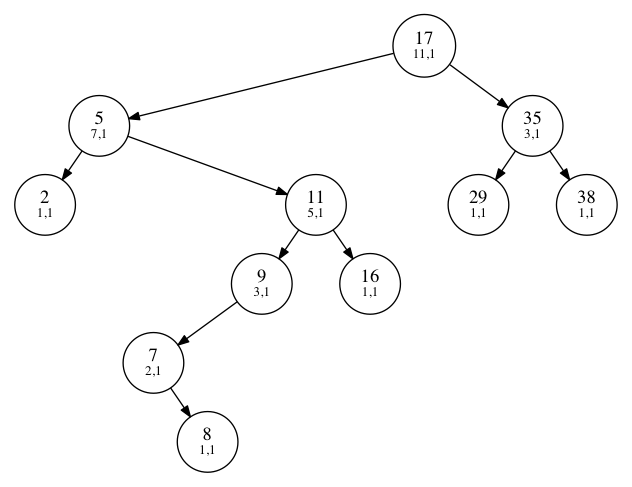

In [10]:
plotbtree(btree, 'oninsertsaug', augmented=True, redo=False)

In [11]:
btreedup = btree_fromlist(duplist, AugmentedBinarySearchTree)
print([e.data for e in btreedup], len(btreedup), len(duplist))

[2, 5, 5, 5, 7, 7, 8, 9, 9, 11, 16, 16, 17, 29, 35, 35, 38] 17 17


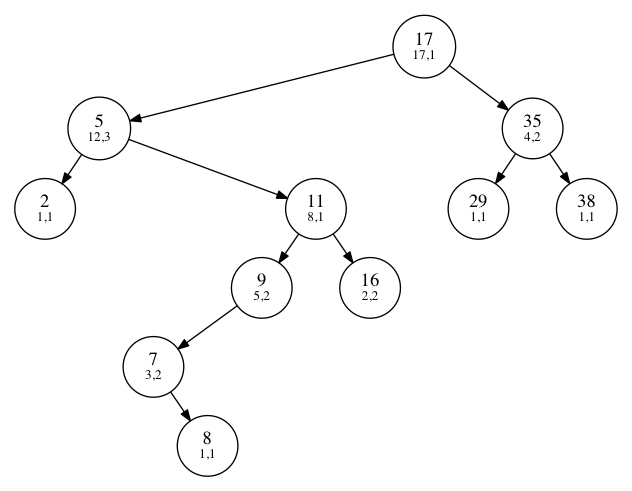

In [12]:
plotbtree(btreedup, 'oninsertsdupaug', augmented=True, redo=False)

In [13]:
for v in ourlist:
    print(v, btree.rankof(v))

17 [8]
5 [2]
35 [10]
2 [1]
11 [6]
29 [9]
38 [11]
9 [5]
16 [7]
7 [3]
8 [4]


In [14]:
for v in duplist:
    print(v, btreedup.rankof(v))

17 [13]
5 [4, 3, 2]
35 [16, 15]
2 [1]
11 [10]
29 [14]
38 [17]
9 [9, 8]
16 [12, 11]
7 [6, 5]
8 [7]
7 [6, 5]
35 [16, 15]
5 [4, 3, 2]
16 [12, 11]
9 [9, 8]
5 [4, 3, 2]


## Q2.

Implement a Key-Value Search true, which allows no duplicates, but rather, updates the value associated with the key. This will change how `insert` works. Inherit from the augmented tree:

`class KeyValueBinarySearchTree(AugmentedBinarySearchTree):`

- The constructor should look like this: `def __init__(self, key_value_tuple, parent=None):`. Pick the key and value out separately in the constructor, and initialize the super with just the key, setting an instance variable `self.value` to the value.
- insert wont duplicate any more, and `addLeftChild` and `addRightChild` will need to take the tuple in as they call the constructor for us.
- implement a `__getitem__`, `__setitem__`, and `__delitem__` so that you can use code like:

`btreekv['f']` for searching

`btreekv['f']=10` for inserting

In [15]:
#your code here
# TODO 

# no duplicates allowed, need to update

class KeyValueBinarySearchTree(AugmentedBinarySearchTree):

    def __init__(self, tup, parent=None):
        data, v = tup
        self.value = v
        self.data = data
        super().__init__(data, parent)

    # Recursive algorithms - think about base case and other case, and everything nicely falls into place
    # Just think of each node as a tree in itself
    def insert(self, tup):
        data, value = tup
        if data < self.data:
            if self.hasLeftChild():
                self.left.insert(tup)
            else:
                self.addLeftChild(tup)
                self._insert_hook()
        elif data > self.data:
            if self.hasRightChild():
                self.right.insert(tup)
            else:
                self.addRightChild(tup)
                self._insert_hook()
        else: #no duplicate value
            self.value = value 
            self._insert_hook()
        
    def __getitem__(self, i):
        if isinstance(i, str):
            return self.ithorder(self.rankof(str(i))[0]).value 
        else:
            return self.ithorder(i+1).value
        
    def __setitem__(self, i, val):
        if isinstance(i, str):      
            return self.insert((str(i), val))           
        else:
            return self.insert(i+1, val)

In [22]:
btreekv = KeyValueBinarySearchTree(('f', 3))

In [23]:
kvdata=zip(list('jeihrifhkdfks'), range(13))

In [18]:
for k,v in kvdata:
    btreekv[k]=v

In [19]:
[(e.data, e.value) for e in list(btreekv)]

[('d', 9),
 ('e', 1),
 ('f', 10),
 ('h', 7),
 ('i', 5),
 ('j', 0),
 ('k', 11),
 ('r', 4),
 ('s', 12)]

In [20]:
btreekv['f']

10

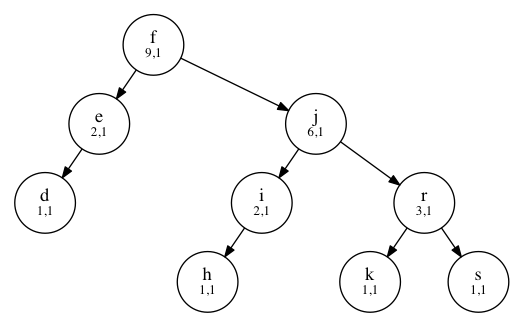

In [21]:
plotbtree(btreekv, 'oninsertsdupaugkv', augmented=True, redo=False)

## Q3.

Use your code to make a third implementation of the `SimpleSet` interface from Monday.

In [ ]:
# My code here

# implement Simplset in terms of this, use this as your storage. Not inheriting from it
# Why didn't he inherit today?  
# augmented BSt is still a BST, dictionary or set is not a BST, but use BST to implement
# that's why we used composition
# we could inherit, but then would start leaking methods of BST out to dictionary which should not do that
# good code practice, don't leak abstractions, even if you technically can. By convention. 
# only the interface that matters 

In [45]:
# from class notes


import abc
class SimpleSetInterface(abc.ABC):
    
    @abc.abstractmethod
    def __len__(self):
        "A SimpleSet has a length"
        
    @abc.abstractmethod
    def __iter__(self):
        "iteration. order is not guaranteed"
    
    @abc.abstractmethod
    def __contains__(self, item)->bool:
        "A test for whether item is in set"
        
    @abc.abstractmethod
    def add(self, item)->None:
        "add item to set"
        
    @abc.abstractmethod
    def rem(self, item)->None:
        "delete item from set"
        
    @abc.abstractmethod
    def union(self, other):
        "union with another set"
        
    @abc.abstractmethod
    def intersection(self, other):
        "intersection with another set"

In [51]:
# TODO 

import reprlib
class SimpleSet3:
    """
    AbsFun: the list [a,b,...,z] represents the
    set  a,b,...,z.
    [] represents the empty set.
    
    RepInv: the list contains no duplicates.
    
    Examples:
    
    >>> A=SimpleSet3([1,2,3,1])
    >>> B=SimpleSet3([2,3,4,4,5])
    >>> sorted(list(A))
    [1, 2, 3]
    >>> sorted(list(A.union(B)))
    [1, 2, 3, 4, 5]
    >>> sorted(list(A.intersection(B)))
    [2, 3]
    >>> A.rem(1)
    >>> sorted(list(A))
    [2, 3]
    >>> C=SimpleSet3()
    >>> C
    {}
    >>> sorted(list(C.union(A)))
    [2, 3]
    >>> sorted(list(C.intersection(A)))
    []
    """
    def __init__(self, container=[]):
        if container:
            self._storage=[]
            for ele in container:
                self.add(ele)#makes sure repinv is respected
        else:
            self._storage = []
        
    def __contains__(self, item):
        if item in self._storage:
            return True
        else:
            return False
        
    def __len__(self):
        return len(self._storage)
    
    def __iter__(self):
        for ele in self._storage:
            yield ele
            
    def add(self, item):
        if item not in self._storage:
            self._storage.append(item)
        
    def rem(self, item): #this is now right
        index = self._storage.remove(item)
        
    def union(self, other):
        s = SimpleSet3(self._storage + other._storage)
        return s
    
    def intersection(self, other):
        intlist = list(filter(lambda x : x in other._storage, self._storage))
        s = SimpleSet3(intlist)
        return s
    
    def __repr__(self):
        return reprlib.repr(self._storage).replace('[','{').replace(']','}')
    

In [52]:
from doctest import run_docstring_examples as dtest
dtest(SimpleSet3, globals(), verbose=True)

Finding tests in NoName
Trying:
    A=SimpleSet3([1,2,3,1])
Expecting nothing
ok
Trying:
    B=SimpleSet3([2,3,4,4,5])
Expecting nothing
ok
Trying:
    sorted(list(A))
Expecting:
    [1, 2, 3]
ok
Trying:
    sorted(list(A.union(B)))
Expecting:
    [1, 2, 3, 4, 5]
ok
Trying:
    sorted(list(A.intersection(B)))
Expecting:
    [2, 3]
ok
Trying:
    A.rem(1)
Expecting nothing
ok
Trying:
    sorted(list(A))
Expecting:
    [2, 3]
ok
Trying:
    C=SimpleSet3()
Expecting nothing
ok
Trying:
    C
Expecting:
    {}
ok
Trying:
    sorted(list(C.union(A)))
Expecting:
    [2, 3]
ok
Trying:
    sorted(list(C.intersection(A)))
Expecting:
    []
ok


In [53]:
SimpleSetInterface.register(SimpleSet3)

__main__.SimpleSet3